In [1]:
!kaggle datasets download -d andrewmvd/car-plate-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
 99% 202M/203M [00:07<00:00, 41.5MB/s]
100% 203M/203M [00:07<00:00, 28.3MB/s]


In [2]:
!unzip car-plate-detection.zip

Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annotations/Cars12.xm

In [3]:
!pip install imutils
!pip install easyocr

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from glob import glob
from shutil import copy
import shutil
import xml.etree.ElementTree as xet
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3 # Import VGG16, ResNet50, and InceptionV3 from keras.applications

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import easyocr
import imutils


In [5]:
# Directories
dataset_path = '/content'

In [6]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)

    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

In [7]:
# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()

    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata.head(3)


,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/images/Cars0.png,226,419,125,173,500,268
1,/content/images/Cars1.png,134,262,128,160,400,248
2,/content/images/Cars2.png,229,270,176,193,400,400


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size = 0.1, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}

      len(test) = {len(test)}
''')


      len(train) = 389

      len(test) = 44



In [9]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images if they don't exist
    os.makedirs(labels_path, exist_ok=True) # Use exist_ok=True to avoid error if directory exists
    os.makedirs(images_path, exist_ok=True) # Use exist_ok=True to avoid error if directory exists

    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [10]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [11]:
train_path="/content/datasets/cars_license_plate_new/train"
test_path="/content/datasets/cars_license_plate_new/test"

In [12]:
train_ds=image_dataset_from_directory(
    train_path,
    image_size=(256,256),
    batch_size=32,
    labels="inferred"
    ,label_mode="int")
test_ds=image_dataset_from_directory(
    test_path,
    image_size=(256,256),
    batch_size=32,
    labels="inferred"
    ,label_mode="int")

Found 389 files belonging to 2 classes.
Found 44 files belonging to 2 classes.


In [13]:
train_ds.class_names

['images', 'labels']

In [14]:
model=Sequential()
resnet=ResNet50(weights="imagenet",include_top=False,input_shape=(256,256,3))
resnet.trainable=False
model.add(resnet)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 23718785 (90.48 MB)
Trainable params: 131073 (512.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [15]:
# Assuming 'test_labels' contains the true labels for your test images
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history=model.fit(train_ds,epochs=5,validation_data=test_ds)

Epoch 1/5
13/13 [==============================] - 16s 551ms/step - loss: 0.0000e+00 - accuracy: 0.5064 - val_loss: 0.0000e+00 - val_accuracy: 0.5455
Epoch 2/5
13/13 [==============================] - 5s 189ms/step - loss: 0.0000e+00 - accuracy: 0.5064 - val_loss: 0.0000e+00 - val_accuracy: 0.5455
Epoch 3/5
13/13 [==============================] - 5s 210ms/step - loss: 0.0000e+00 - accuracy: 0.5064 - val_loss: 0.0000e+00 - val_accuracy: 0.5455
Epoch 4/5
13/13 [==============================] - 6s 183ms/step - loss: 0.0000e+00 - accuracy: 0.5064 - val_loss: 0.0000e+00 - val_accuracy: 0.5455
Epoch 5/5
13/13 [==============================] - 6s 254ms/step - loss: 0.0000e+00 - accuracy: 0.5064 - val_loss: 0.0000e+00 - val_accuracy: 0.5455


In [16]:
#Prediction
prediction=model.predict(test_ds)
prediction

2/2 [==============================] - 2s 144ms/step


array([[0.2782886 ],
       [0.08610835],
       [0.18851781],
       [0.5552475 ],
       [0.09397051],
       [0.9822457 ],
       [0.890693  ],
       [0.82655984],
       [0.81061035],
       [0.21362758],
       [0.65994453],
       [0.6033212 ],
       [0.12532365],
       [0.59693676],
       [0.04914177],
       [0.18032295],
       [0.1095456 ],
       [0.31531802],
       [0.366921  ],
       [0.871069  ],
       [0.99507445],
       [0.292386  ],
       [0.41906238],
       [0.890693  ],
       [0.3676755 ],
       [0.023314  ],
       [0.18851781],
       [0.8669719 ],
       [0.71199566],
       [0.84809965],
       [0.9911583 ],
       [0.58370906],
       [0.67831475],
       [0.22474627],
       [0.7672477 ],
       [0.7708235 ],
       [0.07272357],
       [0.10444612],
       [0.34524402],
       [0.07129309],
       [0.11140556],
       [0.949045  ],
       [0.06841911],
       [0.22474627]], dtype=float32)

In [26]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize
    image = cv2.resize(image, (256, 256))

    # Normalize the image
    image = image / 255.0
    # Expand dimensions to match the model's input shape
    image = np.expand_dims(image, axis=0)
    # Convert the image to a TensorFlow tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Convert the image to a NumPy array
    image = image.numpy()

    # Perform prediction on the test image using the model
    results = model.predict(image)

    # Print the shape and type of the 'results' to inspect the output
    print("Shape of results:", results.shape)
    print("Type of results:", type(results))

    # If your model is a classification model, 'results' might contain class probabilities.
    # You can print or process them as needed. For example:
    print("Predicted probabilities:", results)






    # Plot the original image (since we don't have bounding boxes)
    plt.imshow(image[0]) # Remove the extra dimension added earlier
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image

1/1 [==============================] - 2s 2s/step
Shape of results: (1, 1)
Type of results: <class 'numpy.ndarray'>
Predicted probabilities: [[0.9146738]]


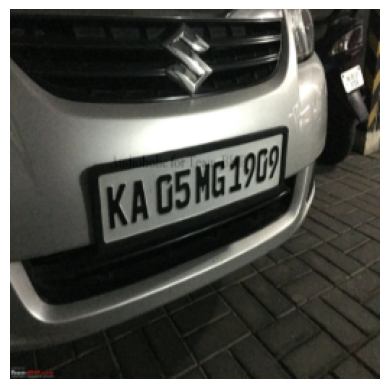

In [27]:
predict_and_plot("/content/datasets/cars_license_plate_new/test/images/Cars126.png")

In [74]:

def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
         # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    bfilter = cv2.bilateralFilter(gray_image, 45, 17, 17) #Noise reduction
    edged = cv2.Canny(bfilter, 30, 200) #Edge detection
    plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

    #contour
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contourss = imutils.grab_contours(keypoints)
    contours = sorted(contourss, key=cv2.contourArea, reverse=True)[:10]



    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 5, True)
        if len(approx) == 4:
            location = approx
            break
    print(location)

   # Check if any valid contour was found
    if location is None:
        print("No valid contour found.")
        return  # Exit the function if no contour is found

    #create window empty and draw Plate
    mask = np.zeros(gray_image.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0,255, -1)
    new_image = cv2.bitwise_and(image, image, mask=mask)


    # coordinate rectangle
    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = new_image[x1:x2+1, y1:y2+1]



    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped_image)

    text = result[0][-2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    res = cv2.putText(image, text=text, org=(approx[0][0][0]-120, approx[1][0][1]+65), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    res = cv2.rectangle(image, (approx[0][0]), (approx[2][0]), (0,255,0),3)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))




    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

[[[475 161]]

 [[324 167]]

 [[324 208]]

 [[475 201]]]


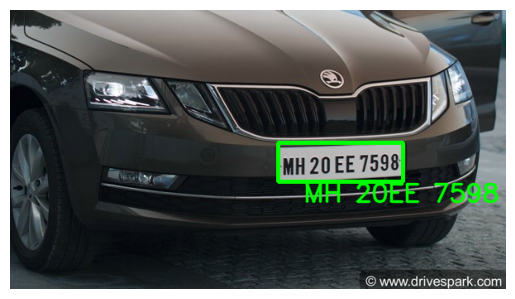

In [75]:
predict_and_plot("/content/datasets/cars_license_plate_new/train/images/Cars111.png")